In [172]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### 1. Carga de datos

In [173]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

### 2. Division y tratamiento de datos

In [174]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [175]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)
    
    # data['ACU_5D_alt'] = data['LMCADY'].rolling(window=5).sum()
    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [176]:
def prepare_data(df, target_column, n_steps, feature_list):
    df = modify_data(df)

    features = df.drop(columns=['LMCADY_std_5d_log', 'Date'])
    features.to_csv('./output/features_and_target_cnn.csv', index=False)
    features = features.drop(columns=[target_column])
    features = features[feature_list]
    print(features.head(5))  # Mostrar las primeras 5 filas de las características

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
    return X_train, X_test, y_train, y_test

In [177]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# # df

In [178]:
# Preparación de los datos
# X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', 10)

In [179]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# # print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
# n_steps = 10
# # Preparación de los datos
# X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

### 3. Arquitectura y compilacion

In [180]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [181]:
def build_model(input_shape, md_prm: dict):
    model = Sequential([
        Conv1D(filters=md_prm['filters']*2, kernel_size=md_prm['kernel_size'], activation=md_prm['activation'], input_shape=input_shape),
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation=md_prm['activation']),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Dropout(md_prm['dropout']/2),
        Flatten(),
        Dense(md_prm['dense_units']*2, activation=md_prm['dense_activation']),
        Dense(md_prm['dense_units'], activation=md_prm['dense_activation']),
        Dense(1, activation = "linear")
    ])
    # puede ser 0.0005
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[rmse])
    return model

### 4. Entrenamiento del modelo

In [182]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

### 5. Evaluacion de resultado

In [183]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [184]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    figsize = (8,2)

    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=figsize)
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [185]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=4):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [186]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [187]:
n_steps_options     = [24,30,35,100]
batch_size_options  = [8,16]
epochs_options      = [100]

filters_options             = [256]
kernel_size_options         = [2]
pool_size_options           = [1,2]
dense_units_options         = [100]
dense_activation_options    = ['tanh']
# dense_activation_options = ['relu']
activation_options          = ['tanh']
# activation_options      = ['relu']
dropout_options             = [0.1,0.2]

variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','ACU_4D','ACU_3D','ACU_2D']

# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
modified_lists = [['LMCADY','SPX','MXWD','XAU','ACU_4D','ACU_3D','ACU_2D']]


model_params_combinations = list(itertools.product(
    filters_options, 
    kernel_size_options, 
    pool_size_options, 
    dense_units_options,
    dense_activation_options, 
    activation_options, 
    dropout_options
))
target_column = 'LMCADY_acu_5d_log'

In [188]:
# number of iterations
n_iter = len(n_steps_options) * len(batch_size_options) * len(epochs_options) * len(model_params_combinations) * len(modified_lists)
print(f'Total iterations: {n_iter}')

Total iterations: 32


In [189]:
def run_model_iterations():
    top_results = []
    iteration = 1

    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units, dense_activation, activation, dropout), feature_list in itertools.product(
            n_steps_options, batch_size_options, epochs_options, model_params_combinations, modified_lists):

        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print(f"\nIteration {iteration}:")
            print(f"Configuration: n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")

            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps, feature_list)

            model_params = {
                'filters': filters,
                'kernel_size': kernel_size,
                'pool_size': pool_size,
                'dense_units': dense_units,
                'dense_activation': dense_activation,
                'activation': activation,
                'dropout': dropout
            }
            model = build_model(X_train.shape[1:], model_params)
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_test)
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))
            std_dev = y_test.std()

            difference = rmse_ob - std_dev
            result = {
                'difference': difference,
                'rmse': rmse_ob,
                'std_dev': std_dev,
                'params': model_params,
                'history': history,
                'batch_size': batch_size,
                'n_steps': n_steps,
                'predictions': y_pred,
                'actuals': y_test,
                'feature_list': feature_list
            }
            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['difference'])

            print(f"Results: RMSE={rmse_ob:.6f}, Std Dev={std_dev:.6f}, Difference={difference:.6f}")

        except Exception as e:
            print(f"An error occurred in iteration {iteration}: {e}. Skipping this configuration.")

        iteration += 1  # Incrementar contador de iteración

    return top_results

In [190]:
top_3_results = run_model_iterations()


1) Testing with n_steps=24, batch_size=8, epochs=100, filters=256
     LMCADY       SPX      MXWD       XAU    ACU_4D    ACU_3D    ACU_2D
0  0.011509  0.019211  0.014910 -0.002492  0.027064  0.016802  0.021281
1 -0.011664 -0.000011  0.002825  0.005654  0.005138  0.009617 -0.000154
2  0.006463 -0.001413  0.000755 -0.000564  0.016080  0.006308 -0.005201
3  0.010982  0.005813  0.007021 -0.009067  0.017291  0.005781  0.017445
4  0.006050 -0.014531 -0.010854 -0.001709  0.011831  0.023495  0.017032
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_102 (Conv1D)         (None, 23, 512)           7680      
                                                                 
 conv1d_103 (Conv1D)         (None, 22, 256)           262400    
                                                                 
 max_pooling1d_51 (MaxPooli  (None, 22, 256)           0         
 ng1D)          


Top 1 Model
Best RMSE: 0.031807 vs. a std of 0.029968, diff = 0.001839
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


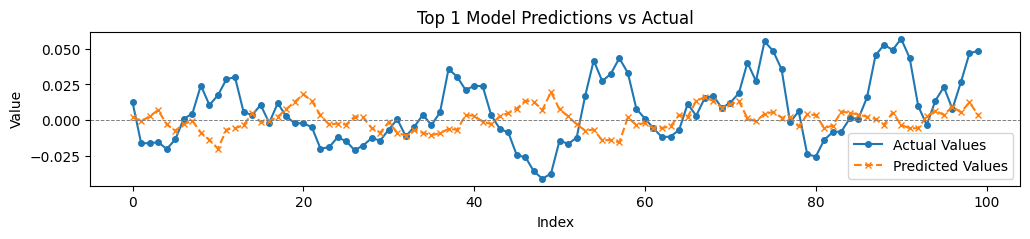


Top 2 Model
Best RMSE: 0.031821 vs. a std of 0.029968, diff = 0.001853
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 8


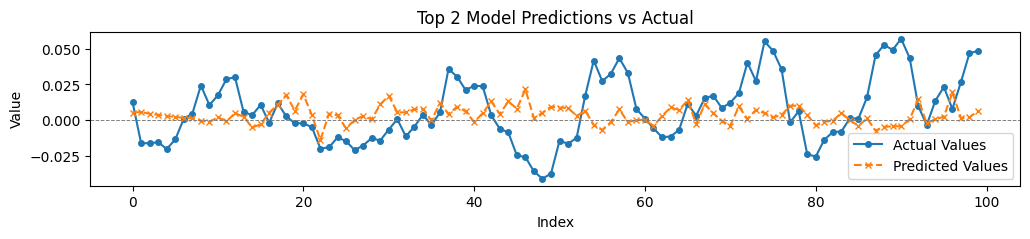


Top 3 Model
Best RMSE: 0.032363 vs. a std of 0.029968, diff = 0.002394
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


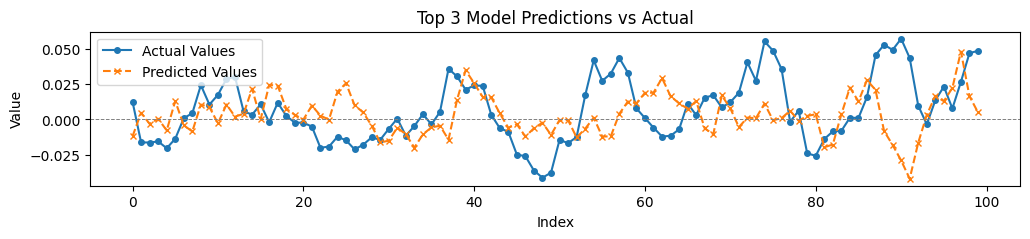


Top 4 Model
Best RMSE: 0.033090 vs. a std of 0.030613, diff = 0.002477
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 16


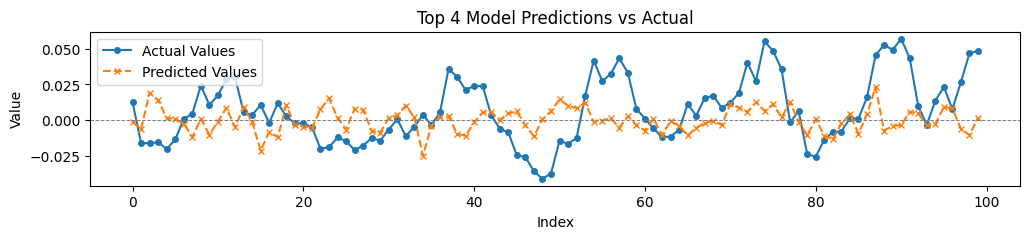


Top 5 Model
Best RMSE: 0.033272 vs. a std of 0.030613, diff = 0.002658
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 16


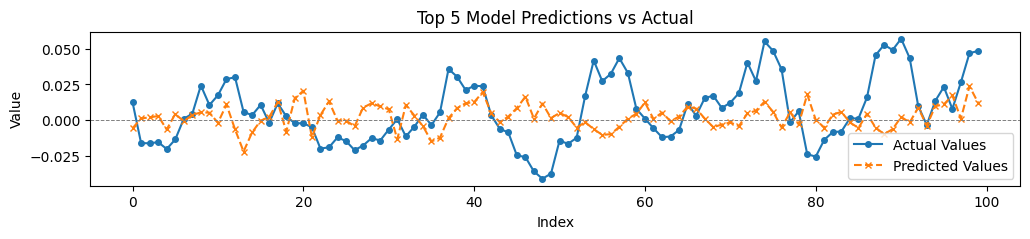


Top 6 Model
Best RMSE: 0.033403 vs. a std of 0.030614, diff = 0.002789
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 16


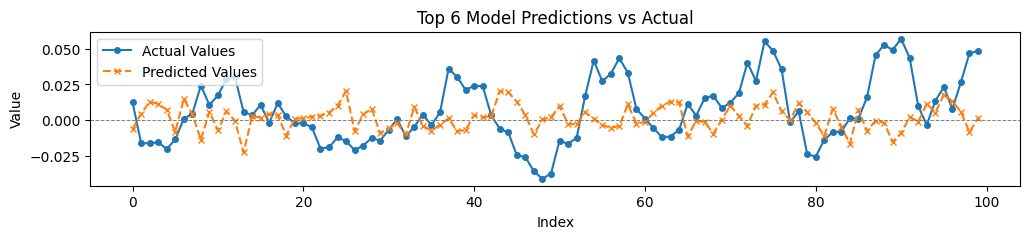


Top 7 Model
Best RMSE: 0.033536 vs. a std of 0.030614, diff = 0.002922
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 16


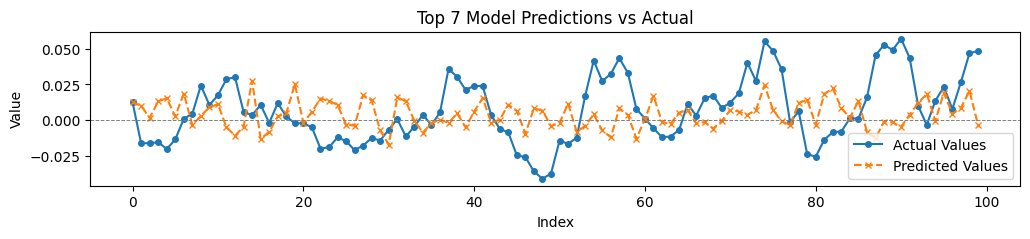


Top 8 Model
Best RMSE: 0.032907 vs. a std of 0.029968, diff = 0.002939
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 8


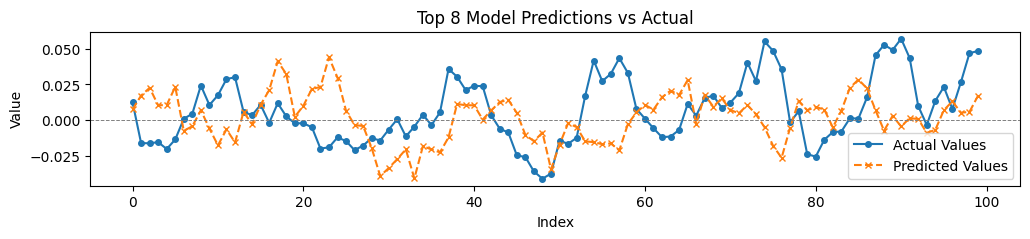


Top 9 Model
Best RMSE: 0.033643 vs. a std of 0.030629, diff = 0.003013
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 16


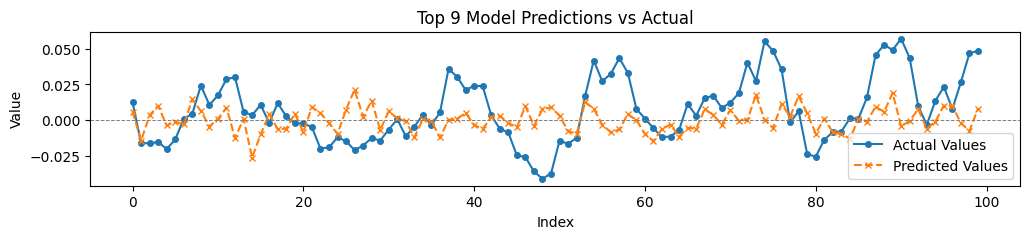


Top 10 Model
Best RMSE: 0.033676 vs. a std of 0.030613, diff = 0.003063
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 8


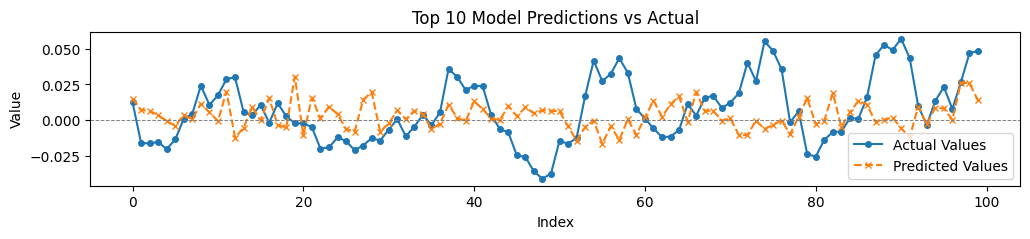


Top 11 Model
Best RMSE: 0.033801 vs. a std of 0.030614, diff = 0.003187
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 8


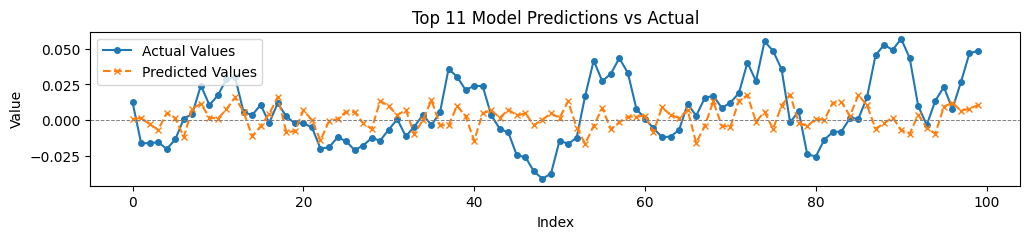


Top 12 Model
Best RMSE: 0.033976 vs. a std of 0.030629, diff = 0.003347
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 16


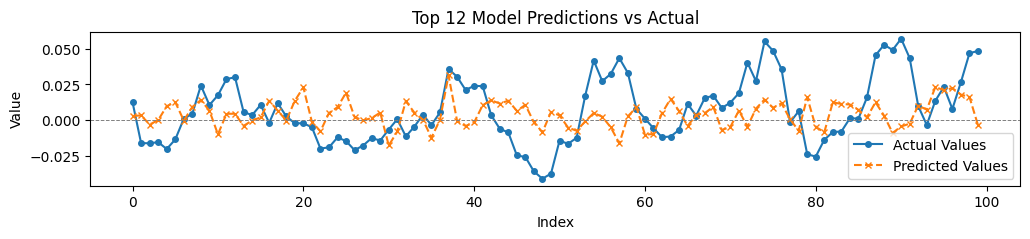


Top 13 Model
Best RMSE: 0.034176 vs. a std of 0.030613, diff = 0.003563
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 8


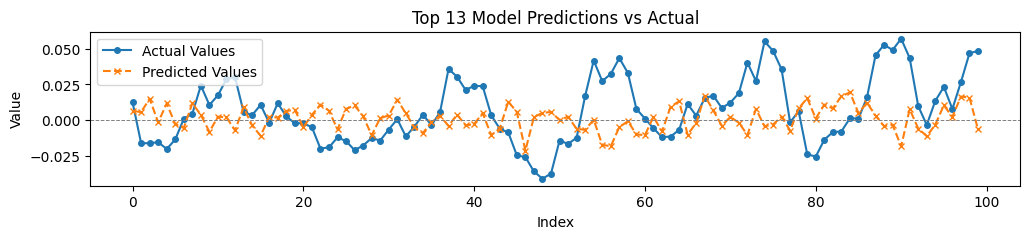


Top 14 Model
Best RMSE: 0.033591 vs. a std of 0.029968, diff = 0.003622
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


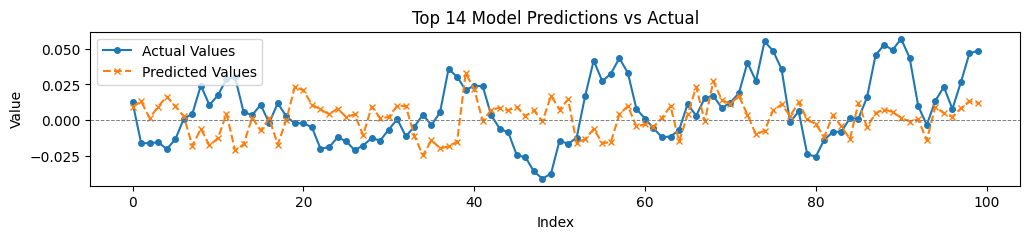


Top 15 Model
Best RMSE: 0.033996 vs. a std of 0.029968, diff = 0.004028
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


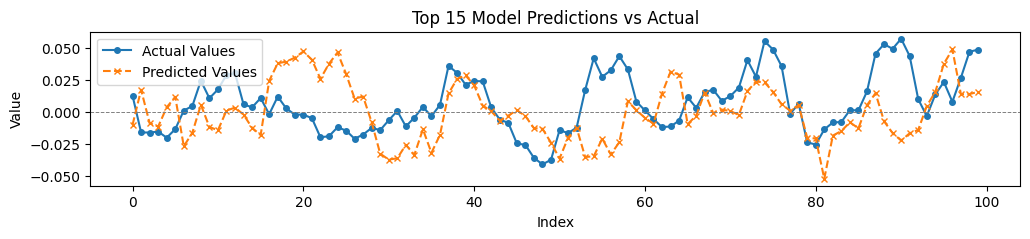


Top 16 Model
Best RMSE: 0.034877 vs. a std of 0.030629, diff = 0.004248
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 8


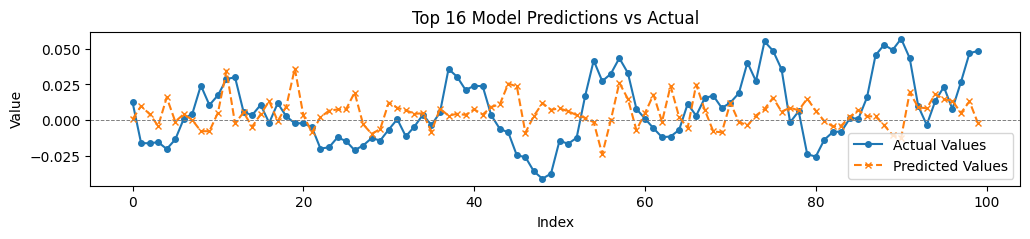


Top 17 Model
Best RMSE: 0.034300 vs. a std of 0.029968, diff = 0.004331
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 8


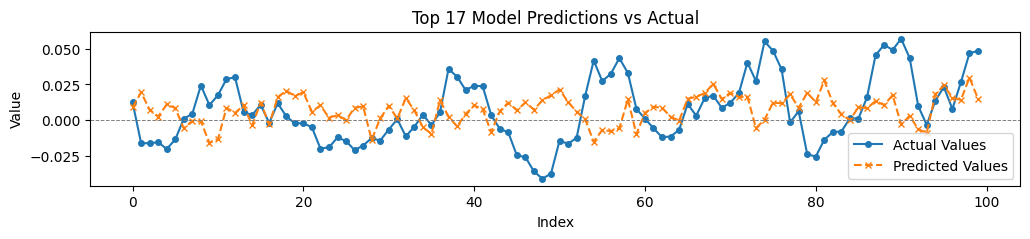


Top 18 Model
Best RMSE: 0.034400 vs. a std of 0.029968, diff = 0.004431
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 8


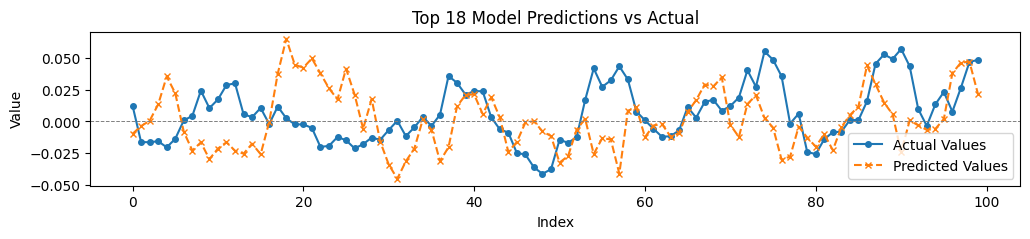


Top 19 Model
Best RMSE: 0.035272 vs. a std of 0.030629, diff = 0.004642
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 8


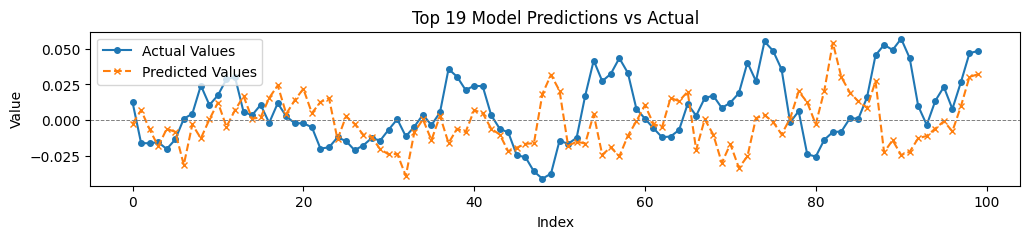


Top 20 Model
Best RMSE: 0.035666 vs. a std of 0.030614, diff = 0.005052
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 8


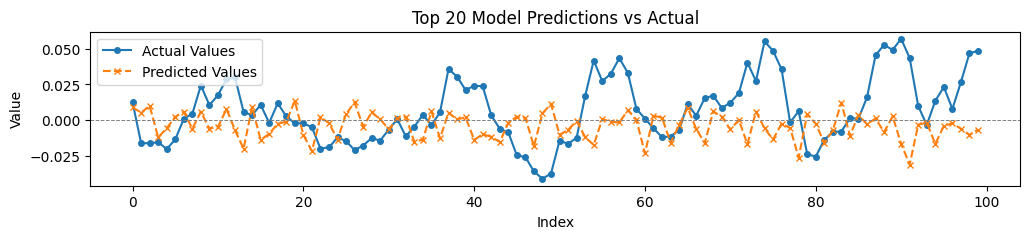


Top 21 Model
Best RMSE: 0.035894 vs. a std of 0.030629, diff = 0.005265
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 8


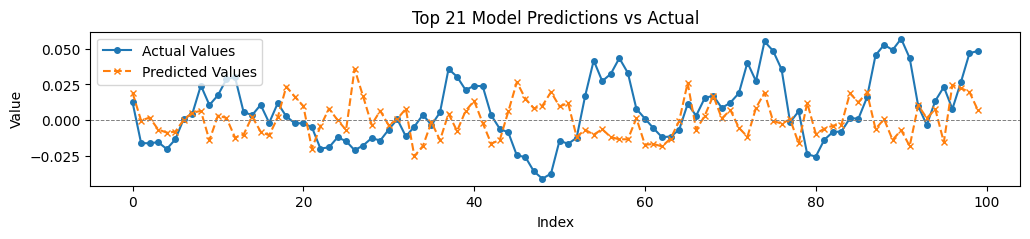


Top 22 Model
Best RMSE: 0.035928 vs. a std of 0.030614, diff = 0.005314
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 16


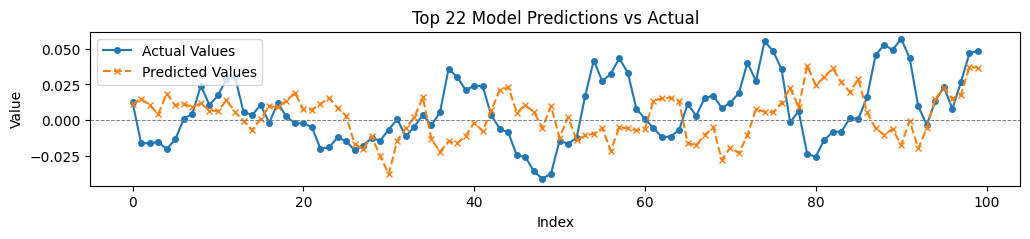


Top 23 Model
Best RMSE: 0.035987 vs. a std of 0.030614, diff = 0.005373
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 16


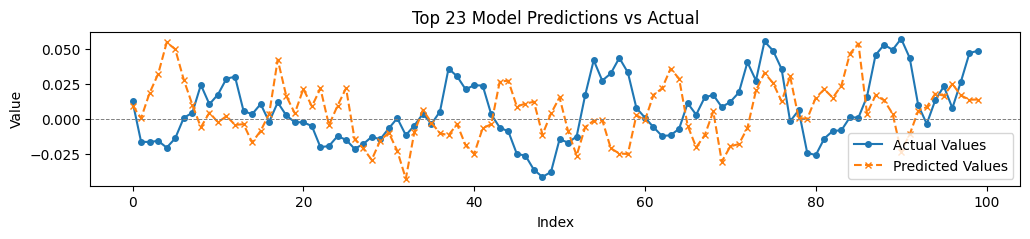


Top 24 Model
Best RMSE: 0.036765 vs. a std of 0.030613, diff = 0.006152
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 8


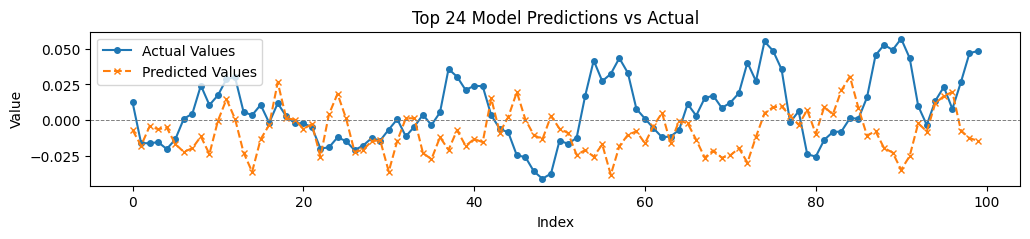


Top 25 Model
Best RMSE: 0.037123 vs. a std of 0.030613, diff = 0.006510
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 16


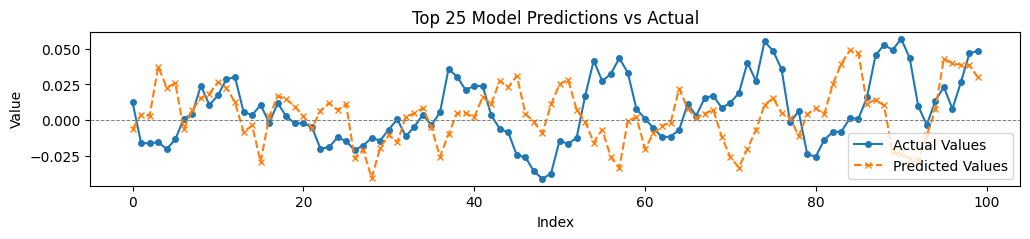


Top 26 Model
Best RMSE: 0.037215 vs. a std of 0.030629, diff = 0.006586
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 16


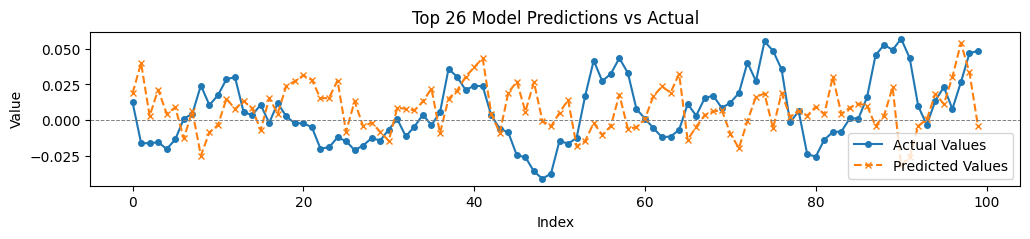


Top 27 Model
Best RMSE: 0.037206 vs. a std of 0.030614, diff = 0.006592
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 8


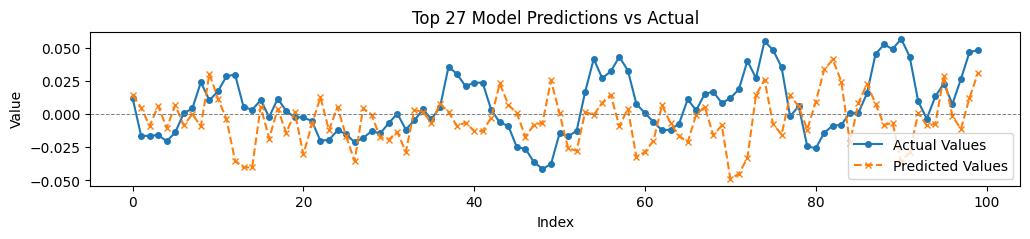


Top 28 Model
Best RMSE: 0.037447 vs. a std of 0.030614, diff = 0.006833
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.2}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 24, batch_size: 8


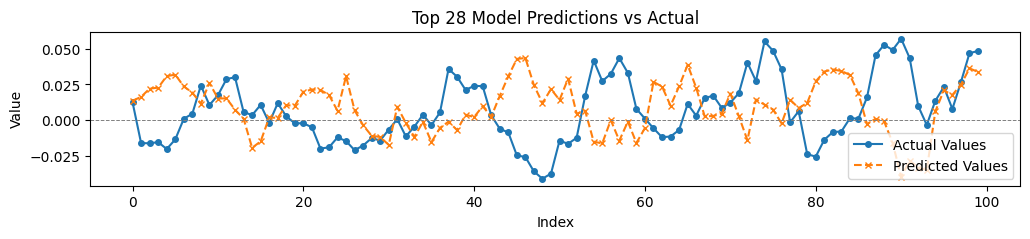


Top 29 Model
Best RMSE: 0.037472 vs. a std of 0.030613, diff = 0.006859
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 8


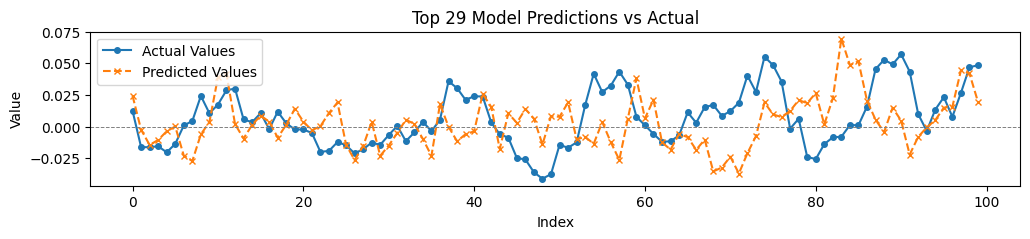


Top 30 Model
Best RMSE: 0.037595 vs. a std of 0.030613, diff = 0.006981
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 30, batch_size: 16


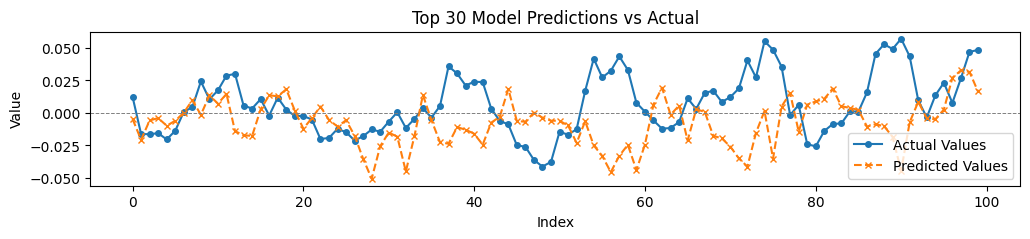


Top 31 Model
Best RMSE: 0.037980 vs. a std of 0.030629, diff = 0.007351
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 16


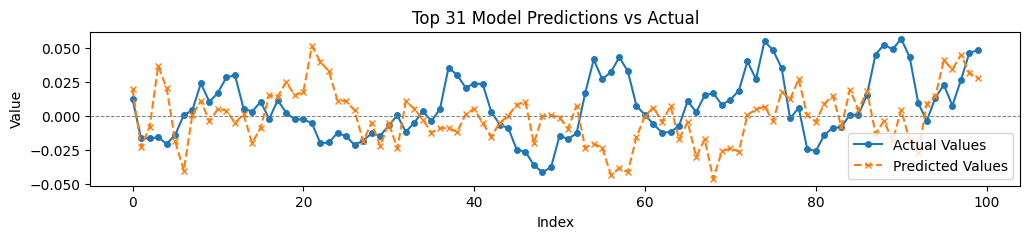


Top 32 Model
Best RMSE: 0.038530 vs. a std of 0.030629, diff = 0.007901
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.1}
Features: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 35, batch_size: 8


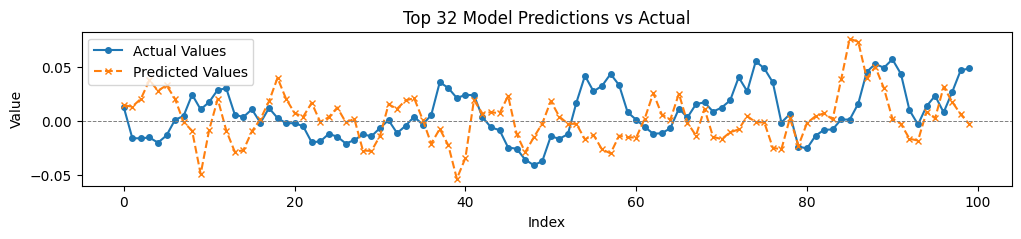

In [191]:
for i, result in enumerate(top_3_results, 1):
    rmse            = result['rmse']
    model_params    = result['params']
    history         = result['history']
    batch_size      = result['batch_size']
    n_steps         = result['n_steps']
    y_test          = result['actuals']
    y_pred          = result['predictions']
    feature_list    = result['feature_list']
    diff = result['difference']

    print(f"\nTop {i} Model")
    print(f"Best RMSE: {rmse:.6f} vs. a std of {y_test.std():.6f}, diff = {diff:.6f}")
    print(f"Model parameters: {model_params}")
    print(f"Features: {feature_list}")
    print(f"n_steps: {n_steps}, batch_size: {batch_size}")

    plot_predictions(y_test, y_pred, 100, title=f"Top {i} Model Predictions vs Actual")


In [192]:
"""
n_steps_options     = [15]
batch_size_options  = [16]
epochs_options      = [100]

filters_options         = [64, 128, 256]
kernel_size_options     = [2, 3, 5]
pool_size_options       = [1, 2]
dense_units_options     = [50, 100, 150]
# dense_activation_options = ['relu', 'tanh']
dense_activation_options = ['relu']
# activation_options      = ['relu', 'tanh']
activation_options      = ['relu']
dropout_options         = [0.1, 0.2, 0.3]
"""

"\nn_steps_options     = [15]\nbatch_size_options  = [16]\nepochs_options      = [100]\n\nfilters_options         = [64, 128, 256]\nkernel_size_options     = [2, 3, 5]\npool_size_options       = [1, 2]\ndense_units_options     = [50, 100, 150]\n# dense_activation_options = ['relu', 'tanh']\ndense_activation_options = ['relu']\n# activation_options      = ['relu', 'tanh']\nactivation_options      = ['relu']\ndropout_options         = [0.1, 0.2, 0.3]\n"